In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tikzplotlib
import numpy as np
import scipy.stats as st
import os
import ruamel.yaml as yaml
from string import Formatter
import re

In [2]:
# plt.style.use('ggplot')
plt.style.use('bmh')
# plt.style.use('seaborn-paper')
# plt.style.use('seaborn')

In [3]:
SPLITTER = re.compile(r"\s+")

In [4]:
def equivalent_error_rate(q1, err, q2, n=500):
    cdf = st.binom.cdf(err * n, n, q1)
    return st.binom.ppf(cdf, n, q2) / n

def equivalent_success_rate(p1, success, p2, n=500):
    return 1 - equivalent_error_rate(1 - p1, 1 - success, 1 - p2, n=500)

In [5]:
def load_many(path: str, folders: list, results_file: str = "training_log.csv", fstring: str = ""):
    data = {}
    labels = {}
    fieldnames = [field for _, field, _, _ in Formatter().parse(fstring) if field]
    for folder in folders:
        fname = os.path.join(path, folder, results_file)
        data[folder] = pd.read_csv(fname)
        
        fname = os.path.join(path, folder, "settings.yml")
        with open(fname) as f:
            settings = yaml.safe_load(f)
        kwargs = {}
        for field in fieldnames:
            if "?" in field:
                var, booltext = field.split("?")
                kwargs[field] = booltext if settings[var] else ""
            else:
                kwargs[field] = settings[field]
        label = fstring.format(**kwargs)
        try:
            final_stats_file = os.path.join(path, folder, "final_stats.yaml")
            with open(final_stats_file) as f:
                final_stats = yaml.load(f)
#                 print(final_stats["exit_status"])
            if final_stats["exit_status"] == "error":
                label = f"*{label}"
        except:
            pass
        labels[folder] = label
    return data, labels

def plot_many(data, labels, field, goal=None, smooth_window=1, ax=None, ylabel="Success rate", xlabel="Episode", legend=True):
    if ax is None:
        ax = plt.axes()
    for key in data:
        label = labels[key]
        df = data[key]
        episodes = df["episode"]
        curve = df[field]
        smooth_curve = curve.rolling(window=smooth_window).mean()
        ax.plot(episodes, smooth_curve, label=label, linewidth=1.1)
    if goal:
        ax.plot(episodes, np.ones_like(episodes)*goal, color='black', linestyle='dotted')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if legend:
        ax.legend(loc="best")
    
def add_frequent_symbols(data, window_length, threshold):
    for df in data.values():
        n_symbols = df["symbol"].nunique()
        print(f"{n_symbols} unique symbols")
        counts = pd.get_dummies(df["symbol"]).rolling(window_length).sum()
        frequent_symbols = counts.gt(threshold).sum(axis=1)
#         frequent_symbols = counts.gt(threshold*window_length/n_symbols).sum(axis=1)
        frequent_symbols[:window_length] = np.NaN
        df["frequent_symbols"] = frequent_symbols


# Exp 1: REINFORCE

<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)


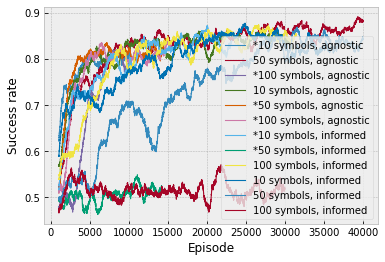

In [49]:
name = "e1-initial"
folders = """
e1-initial-210522-184838
e1-initial-210522-185258
e1-initial-210522-191018
e1-initial-210522-191441
e1-initial-210522-192819
e1-initial-210522-193505
e1-initial-210522-194205
e1-initial-210522-195258
e1-initial-210522-195941
e1-initial-210522-201425
e1-initial-210522-203034
e1-initial-210522-204924
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "{vocabulary_size} symbols, {sender_type}"
)

plot_many(data, labels, "success", smooth_window=1000)
figure = plt.gcf()

plt.savefig(f"{name}.png", dpi=200)
# tikzplotlib.save(f"{name}.tex")

In [54]:
for d, l in zip(data.values(), labels.values()):
    print(l)
#     print(d["success"][-1000:].mean())

*10 symbols, agnostic
50 symbols, agnostic
*100 symbols, agnostic
10 symbols, agnostic
*50 symbols, agnostic
*100 symbols, agnostic
*10 symbols, informed
*50 symbols, informed
100 symbols, informed
10 symbols, informed
50 symbols, informed
100 symbols, informed


<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)
<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)


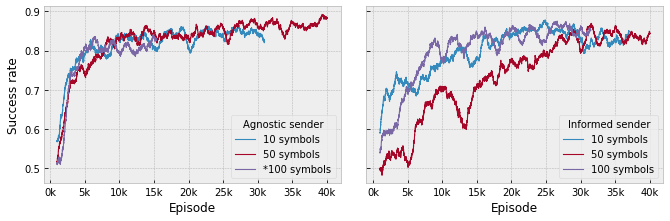

In [63]:
name = "e1-initial"

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

############

folders = """
e1-initial-210522-191441
e1-initial-210522-185258
e1-initial-210522-193505
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "{vocabulary_size} symbols"
)

plot_many(data, labels, "success", ax=ax1, smooth_window=1000)

#############

folders = """
e1-initial-210522-201425
e1-initial-210522-203034
e1-initial-210522-195941
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "{vocabulary_size} symbols"
)

plot_many(data, labels, "success", ax=ax2, ylabel=None, smooth_window=1000)

#############

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax1.legend(title='Agnostic sender')
ax2.legend(title='Informed sender')

plt.tight_layout()
fig.set_size_inches(10, 3)

plt.savefig(f"{name}.png", dpi=200, bbox_inches="tight")
tikzplotlib.save(f"{name}.tex")

<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)
<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)


10 unique symbols
49 unique symbols
85 unique symbols
10 unique symbols
50 unique symbols
90 unique symbols


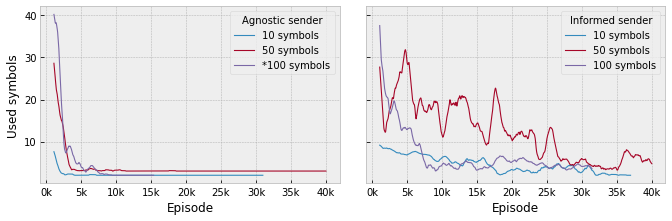

In [68]:
name = "e1-freq-symbols"

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

############

folders = """
e1-initial-210522-191441
e1-initial-210522-185258
e1-initial-210522-193505
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "{vocabulary_size} symbols"
)

add_frequent_symbols(data, 100, 0)
plot_many(data, labels, "frequent_symbols", ax=ax1, ylabel="Used symbols", smooth_window=1000)

#############

folders = """
e1-initial-210522-201425
e1-initial-210522-203034
e1-initial-210522-195941
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "{vocabulary_size} symbols"
)

add_frequent_symbols(data, 100, 0)
plot_many(data, labels, "frequent_symbols", ax=ax2, ylabel=None, smooth_window=1000)

#############

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax1.legend(title='Agnostic sender')
ax2.legend(title='Informed sender')

plt.tight_layout()
fig.set_size_inches(10, 3)

plt.savefig(f"{name}.png", dpi=200, bbox_inches="tight")
tikzplotlib.save(f"{name}.tex")

<ipython-input-41-b278e3a54244>:23: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)
<ipython-input-41-b278e3a54244>:23: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)


10 unique symbols
49 unique symbols
85 unique symbols
10 unique symbols
50 unique symbols
90 unique symbols


<ipython-input-50-4f1f333bdcbc>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


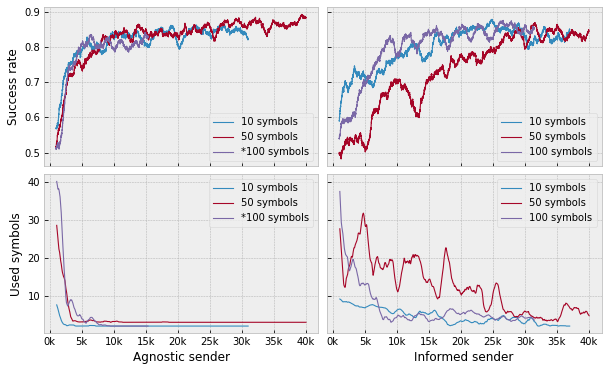

In [50]:
name = "e1-success-symbols"

# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig = plt.figure()
# grid = fig.add_gridspec(2, 2)
grid = fig.add_gridspec(2, 2, hspace=0.05, wspace=0.03)
(ax1, ax2), (ax3, ax4) = grid.subplots(sharex='col', sharey='row')

############

folders = """
e1-initial-210522-191441
e1-initial-210522-185258
e1-initial-210522-193505
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "{vocabulary_size} symbols"
)

plot_many(data, labels, "success", ax=ax1, xlabel=None, smooth_window=1000)

add_frequent_symbols(data, 100, 0)
plot_many(data, labels, "frequent_symbols", ax=ax3, xlabel="Agnostic sender", ylabel="Used symbols", smooth_window=1000)

#############

folders = """
e1-initial-210522-201425
e1-initial-210522-203034
e1-initial-210522-195941
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "{vocabulary_size} symbols"
)

plot_many(data, labels, "success", ax=ax2, ylabel=None, xlabel=None, smooth_window=1000)

add_frequent_symbols(data, 100, 0)
plot_many(data, labels, "frequent_symbols", ax=ax4, xlabel="Informed sender", ylabel=None, smooth_window=1000)

#############

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax3.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax4.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
# ax1.legend(title='4 images')
# ax2.legend(title='6 images')

plt.tight_layout()
fig.set_size_inches(10, 6)

plt.savefig(f"{name}.png", dpi=200, bbox_inches="tight")
# tikzplotlib.save(f"{name}.tex")

## Explore temperature

In [73]:
folders = """
e1-explore-temp-210519-224929
e1-explore-temp-210519-225124
e1-explore-temp-210519-215110
e1-explore-temp-210519-220458
e1-explore-temp-210519-222000
e1-explore-temp-210519-223511
e1-explore-temp-210520-000257
e1-explore-temp-210520-001205
e1-explore-temp-210519-225725
e1-explore-temp-210519-231133
e1-explore-temp-210519-232929
e1-explore-temp-210519-234643
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "{sender_type} temp {temperature}, seed {seed}"
)

for d, l in zip(data.values(), labels.values()):
    print(l)
#     print(d["success"][-1000:].mean())

<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)


*agnostic temp 5, seed 1
*agnostic temp 5, seed 22
*agnostic temp 10, seed 1
agnostic temp 10, seed 22
agnostic temp 50, seed 1
agnostic temp 50, seed 22
*informed temp 5, seed 1
*informed temp 5, seed 22
informed temp 10, seed 1
informed temp 10, seed 22
informed temp 50, seed 1
informed temp 50, seed 22


In [ ]:
for d, l in zip(data.values(), labels.values()):
    print(l)
#     print(d["success"][-1000:].mean())

<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)
<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)


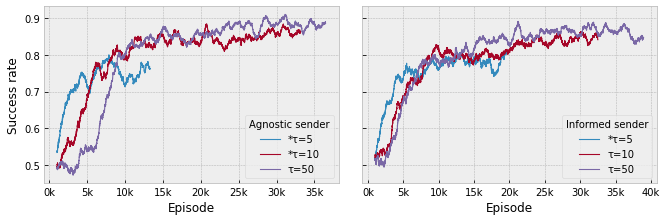

In [66]:
name = "e1-explore-temp-select"

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

############

folders = """
e1-explore-temp-210519-225124
e1-explore-temp-210519-215110
e1-explore-temp-210519-222000
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "τ={temperature}"
)

plot_many(data, labels, "success", ax=ax1, smooth_window=1000)

#############

folders = """
e1-explore-temp-210520-001205
e1-explore-temp-210519-225725
e1-explore-temp-210519-232929
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "τ={temperature}"
)

plot_many(data, labels, "success", ax=ax2, ylabel=None, smooth_window=1000)

#############

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax1.legend(title='Agnostic sender')
ax2.legend(title='Informed sender')

plt.tight_layout()
fig.set_size_inches(10, 3)

plt.savefig(f"{name}.png", dpi=200, bbox_inches="tight")
tikzplotlib.save(f"{name}.tex")

# Exp 2: Q-Learning

<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)


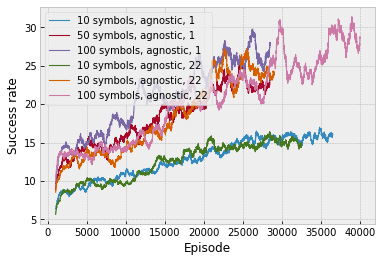

In [46]:
name = "e2-qlearning-test"
folders = """
e2-qlearning-210520-002056
e2-qlearning-210520-003555
e2-qlearning-210520-004735
e2-qlearning-210520-005943
e2-qlearning-210520-011343
e2-qlearning-210520-012617
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "{vocabulary_size} symbols, {sender_type}, {seed}"
)

plot_many(data, labels, "receiver_loss", smooth_window=1000)
figure = plt.gcf()

# plt.savefig(f"{name}.png", dpi=200)
# tikzplotlib.save(f"{name}.tex")

In [44]:
for d, l in zip(data.values(), labels.values()):
    print(d["success"][-1000:].mean())

0.482
0.51
0.49
0.51
0.48
0.5


<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)
<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)


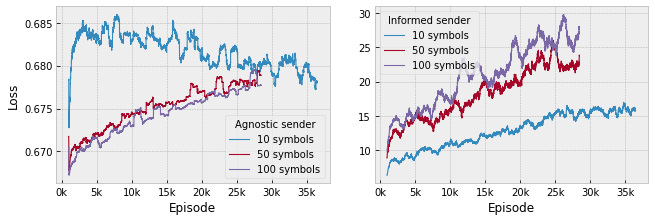

In [69]:
name = "e2-qlearning-losses"

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False)

############

folders = """
e2-qlearning-210520-002056
e2-qlearning-210520-003555
e2-qlearning-210520-004735
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "{vocabulary_size} symbols"
)

plot_many(data, labels, "sender_loss", ax=ax1, ylabel="Loss", smooth_window=1000)

#############

folders = """
e2-qlearning-210520-002056
e2-qlearning-210520-003555
e2-qlearning-210520-004735
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "{vocabulary_size} symbols"
)

plot_many(data, labels, "receiver_loss", ax=ax2, ylabel=None, smooth_window=1000)

#############

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax1.legend(title='Agnostic sender')
ax2.legend(title='Informed sender')

plt.tight_layout()
fig.set_size_inches(10, 3)

plt.savefig(f"{name}.png", dpi=200, bbox_inches="tight")
# tikzplotlib.save(f"{name}.tex")

# Exp 3: More images

In [93]:
folders = """
e3-4images-210523-005440
e3-4images-210523-011150
e3-4images-210523-012701
e3-4images-210523-014425
e3-4images-210523-020417
e3-4images-210523-022405
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "τ={temperature}, seed {seed}"
)

for d, l in zip(data.values(), labels.values()):
    print(d["success"][-1000:].mean(), end="")
    print("\t", end="")
    print(l, end="")
    print()

#############

folders = """
e3-6images-210523-024413
e3-6images-210523-030415
e3-6images-210523-031950
e3-6images-210523-033720
e3-6images-210523-035555
e3-6images-210523-041531
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "τ={temperature}, seed {seed}"
)

for d, l in zip(data.values(), labels.values()):
    print(d["success"][-1000:].mean(), end="")
    print("\t", end="")
    print(l, end="")
    print()

<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)


0.238	τ=30, seed 1
0.459	τ=60, seed 1
0.446	τ=100, seed 1
0.458	τ=30, seed 22
0.592	τ=60, seed 22
0.617	τ=100, seed 22
0.176	τ=30, seed 1
0.305	τ=60, seed 1
0.44	τ=100, seed 1
0.156	τ=30, seed 22
0.178	τ=60, seed 22
0.311	τ=100, seed 22


<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)


50 unique symbols
50 unique symbols
50 unique symbols


<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)


40 unique symbols
50 unique symbols
50 unique symbols


<ipython-input-108-4665970c7af1>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


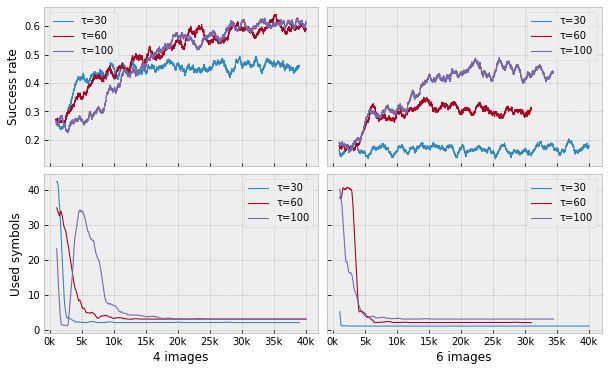

In [108]:
name = "e3-success"

# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig = plt.figure()
# grid = fig.add_gridspec(2, 2)
grid = fig.add_gridspec(2, 2, hspace=0.05, wspace=0.03)
(ax1, ax2), (ax3, ax4) = grid.subplots(sharex='col', sharey='row')

############

folders = """
e3-4images-210523-014425
e3-4images-210523-020417
e3-4images-210523-022405
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "τ={temperature}"
)

plot_many(data, labels, "success", ax=ax1, xlabel=None, smooth_window=1000)

add_frequent_symbols(data, 100, 0)
plot_many(data, labels, "frequent_symbols", ax=ax3, xlabel="4 images", ylabel="Used symbols", smooth_window=1000)

#############

folders = """
e3-6images-210523-024413
e3-6images-210523-030415
e3-6images-210523-031950
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "τ={temperature}"
)

plot_many(data, labels, "success", ax=ax2, ylabel=None, xlabel=None, smooth_window=1000)

add_frequent_symbols(data, 100, 0)
plot_many(data, labels, "frequent_symbols", ax=ax4, xlabel="6 images", ylabel=None, smooth_window=1000)

#############

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax3.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax4.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
# ax1.legend(title='4 images')
# ax2.legend(title='6 images')

plt.tight_layout()
fig.set_size_inches(10, 6)

plt.savefig(f"{name}.png", dpi=200, bbox_inches="tight")
# tikzplotlib.save(f"{name}.tex")

44 unique symbols
50 unique symbols
48 unique symbols
50 unique symbols


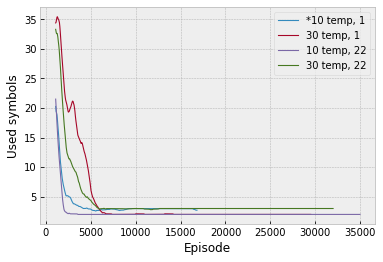

In [75]:
add_frequent_symbols(data, 100, 0)
plot_many(data, labels, "frequent_symbols", ylabel="Used symbols", smooth_window=1000)

# Role switching

<ipython-input-6-4209aa8e4263>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)
<ipython-input-6-4209aa8e4263>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)


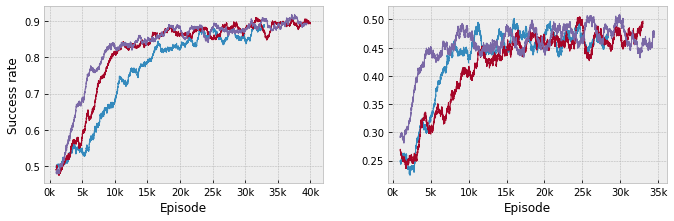

In [11]:
name = "e4-switch"

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False)

############

folders = """
e4-switch-2img-210523-135233
e4-switch-2img-210523-140624
e4-switch-2img-210523-142302
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "seed {seed}"
)

plot_many(data, labels, "success", ax=ax1, smooth_window=1000, legend=False)

#############

folders = """
e4-switch-4img-210523-153036
e4-switch-4img-210523-154352
e4-switch-4img-210523-155929
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "seed {seed}"
)

plot_many(data, labels, "success", ax=ax2, ylabel=None, smooth_window=1000, legend=False)

#############

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
# ax1.legend(title='2 images')
# ax2.legend(title='4 images')

plt.tight_layout()
fig.set_size_inches(10, 3)

# plt.savefig(f"{name}.png", dpi=200, bbox_inches="tight")
# tikzplotlib.save(f"{name}.tex")

In [110]:
folders = """
e4-switch-2img-210523-135233
e4-switch-2img-210523-140624
e4-switch-2img-210523-142302
e4-switch-2img-210523-143928
e4-switch-2img-210523-145606
e4-switch-2img-210523-151234
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "{shared_experience} sharexp, temp {temperature}, seed {seed}"
)

for d, l in zip(data.values(), labels.values()):
    print(d["success"][-1000:].mean(), end="")
    print("\t", end="")
    print(l, end="")
    print()
    
folders = """
e4-switch-4img-210523-153036
e4-switch-4img-210523-154352
e4-switch-4img-210523-155929
e4-switch-4img-210523-161609
e4-switch-4img-210523-163359
e4-switch-4img-210523-164913
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "{shared_experience} sharexp, temp {temperature}, seed {seed}"
)

for d, l in zip(data.values(), labels.values()):
    print(d["success"][-1000:].mean(), end="")
    print("\t", end="")
    print(l, end="")
    print()

<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)


0.884	False sharexp, temp 50, seed 1
0.893	False sharexp, temp 50, seed 22
0.894	False sharexp, temp 50, seed 333
0.863	True sharexp, temp 50, seed 1
0.893	True sharexp, temp 50, seed 22
0.894	True sharexp, temp 50, seed 333
0.482	False sharexp, temp 80, seed 1
0.497	False sharexp, temp 80, seed 22
0.475	False sharexp, temp 80, seed 333
0.384	True sharexp, temp 80, seed 1
0.497	True sharexp, temp 80, seed 22
0.475	True sharexp, temp 80, seed 333


<ipython-input-41-b278e3a54244>:23: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)
<ipython-input-41-b278e3a54244>:23: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)
<ipython-input-47-cc512f56d98e>:46: UserWarning: This figure includes Axes that are not compatible wit

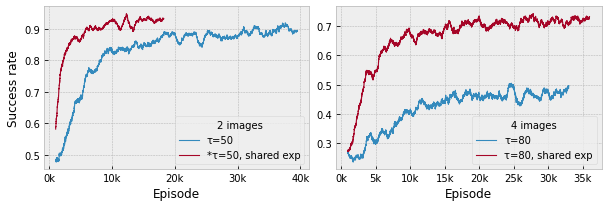

In [47]:
name = "e4-switch-shared"

fig = plt.figure()
grid = fig.add_gridspec(1, 2, wspace=0.1)
(ax1, ax2) = grid.subplots(sharey=False)

############

folders = """
e4-switch-2img-210523-142302
e4-switch-2img-210524-124621
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "τ={temperature}{shared_experience?, shared exp}"
)

plot_many(data, labels, "success", ax=ax1, smooth_window=1000, legend=False)

#############

folders = """
e4-switch-4img-210523-154352
e4-switch-4img-210524-140539
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "τ={temperature}{shared_experience?, shared exp}"
)

plot_many(data, labels, "success", ax=ax2, ylabel=None, smooth_window=1000, legend=False)

#############

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax1.legend(title='2 images')
ax2.legend(title='4 images')

plt.tight_layout()
fig.set_size_inches(10, 3)

plt.savefig(f"{name}.png", dpi=200, bbox_inches="tight")
# tikzplotlib.save(f"{name}.tex")

<ipython-input-6-b278e3a54244>:23: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)
<ipython-input-6-b278e3a54244>:23: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)
<ipython-input-6-b278e3a54244>:23: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without

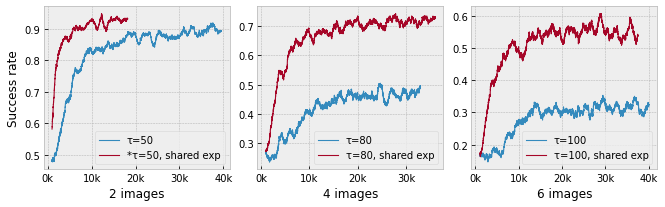

In [15]:
name = "e4-success-3"

fig = plt.figure()
grid = fig.add_gridspec(1, 3, wspace=0.15)
(ax1, ax2, ax3) = grid.subplots(sharey=False)

############

folders = """
e4-switch-2img-210523-142302
e4-switch-2img-210524-124621
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "τ={temperature}{shared_experience?, shared exp}"
)

plot_many(data, labels, "success", ax=ax1, xlabel='2 images', smooth_window=1000, legend=True)

#############

folders = """
e4-switch-4img-210523-154352
e4-switch-4img-210524-140539
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "τ={temperature}{shared_experience?, shared exp}"
)

plot_many(data, labels, "success", ax=ax2, xlabel='4 images', ylabel=None, smooth_window=1000, legend=True)

#############

folders = """
e4-switch-6img-210524-200612
e4-switch-6img-210524-204656
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "τ={temperature}{shared_experience?, shared exp}"
)

plot_many(data, labels, "success", ax=ax3, xlabel='6 images', ylabel=None, smooth_window=1000, legend=True)

#############

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax3.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
# ax1.legend(title='2 images')
# ax2.legend(title='4 images')
# ax3.legend(title='6 images')

plt.tight_layout()
fig.set_size_inches(11, 3)

plt.savefig(f"{name}.png", dpi=200, bbox_inches="tight")
# tikzplotlib.save(f"{name}.tex")

In [38]:
"{a?abc}".format(**{"a?abc": 3})

'3'

<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)


50 unique symbols
50 unique symbols
50 unique symbols
50 unique symbols


<ipython-input-25-cc885e1f0c41>:19: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)


50 unique symbols
50 unique symbols
50 unique symbols
50 unique symbols


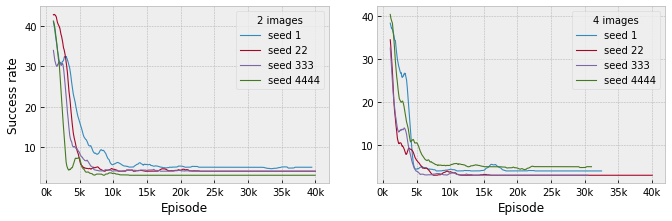

In [80]:
name = "e4-frequent-symbols"

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False)

############

folders = """
e4-switch-2images-210520-032820
e4-switch-2images-210520-034423
e4-switch-2images-210520-040046
e4-switch-2images-210520-041708
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "seed {seed}"
)

add_frequent_symbols(data, 100, 0)
plot_many(data, labels, "frequent_symbols", ax=ax1, smooth_window=1000)

#############

folders = """
e4-switch-4images-210520-043339
e4-switch-4images-210520-044849
e4-switch-4images-210520-050746
e4-switch-4images-210520-052225
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "seed {seed}"
)

add_frequent_symbols(data, 100, 0)
plot_many(data, labels, "frequent_symbols", ax=ax2, ylabel=None, smooth_window=1000)

#############

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))
ax1.legend(title='2 images')
ax2.legend(title='4 images')

plt.tight_layout()
fig.set_size_inches(10, 3)

# plt.savefig(f"{name}.png", dpi=200, bbox_inches="tight")
# tikzplotlib.save(f"{name}.tex")

In [ ]:
labels

<ipython-input-6-b278e3a54244>:23: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)


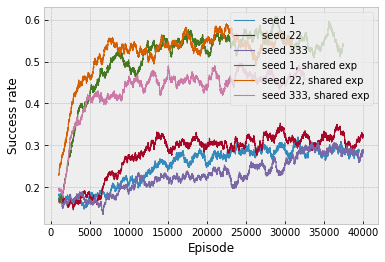

In [9]:
folders = """
e4-switch-6img-210524-194615
e4-switch-6img-210524-200612
e4-switch-6img-210524-202631
e4-switch-6img-210524-204656
e4-switch-6img-210524-211609
e4-switch-6img-210524-214312
"""

data, labels = load_many(
    "models", 
    SPLITTER.split(folders.strip()), 
    "training_log.csv", 
    "seed {seed}{shared_experience?, shared exp}"
)

plot_many(data, labels, "success", smooth_window=1000)

In [2]:
folders = """
/home/robin/thesis/guessing-game/top-models/e1-explore-temp-210519-222000
/home/robin/thesis/guessing-game/top-models/e3-4images-210523-022405
/home/robin/thesis/guessing-game/top-models/e3-6images-210523-031950
/home/robin/thesis/guessing-game/top-models/e4-switch-2img-210523-142302
/home/robin/thesis/guessing-game/top-models/e4-switch-2img-210524-124621
/home/robin/thesis/guessing-game/top-models/e4-switch-4img-210523-154352
/home/robin/thesis/guessing-game/top-models/e4-switch-4img-210524-140539
/home/robin/thesis/guessing-game/top-models/e4-switch-6img-210524-200612
/home/robin/thesis/guessing-game/top-models/e4-switch-6img-210524-204656
"""
for f in folders.split("\n"):
    print(f.split("/")[-1])


e1-explore-temp-210519-222000
e3-4images-210523-022405
e3-6images-210523-031950
e4-switch-2img-210523-142302
e4-switch-2img-210524-124621
e4-switch-4img-210523-154352
e4-switch-4img-210524-140539
e4-switch-6img-210524-200612
e4-switch-6img-210524-204656



In [11]:
folders = """
e1-explore-temp-210519-222000
e4-switch-2img-210523-142302
e4-switch-2img-210524-124621
e3-4images-210523-022405
e4-switch-4img-210523-154352
e4-switch-4img-210524-140539
e3-6images-210523-031950
e4-switch-6img-210524-200612
e4-switch-6img-210524-204656
"""

# folders = """
# e4-switch-2img-210523-142302
# e4-switch-2img-210524-124621
# e4-switch-4img-210523-154352
# e4-switch-4img-210524-140539
# e4-switch-6img-210524-200612
# e4-switch-6img-210524-204656
# """

data, labels = load_many(
    "top-models", 
    SPLITTER.split(folders.strip()), 
#     "10000games.results.csv", 
    "10000games-same.results.csv", 
#     "10000games-alt.results.csv", 
#     "training_log.csv", 
    "{shared_experience} sharexp, temp {temperature}, seed {seed}"
)

for d, l, f in zip(data.values(), labels.values(), SPLITTER.split(folders.strip())):
    print(d["success"][-1000:].mean(), end="")
#     print(",", end="")
#     print(f, end="")
    print()

0.758
0.817
0.795
0.477
0.417
0.524
0.331
0.28
0.409


<ipython-input-5-b278e3a54244>:23: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  final_stats = yaml.load(f)
